In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [2]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant

In [3]:
df_param_space_A5 = pd.read_csv('data/para_space_A5.csv') .drop(0).rename(columns={"Unnamed: 0": "Variable"})

In [17]:
df_param_space_A5

,Variable,box 15,box 15.1,box 15.2,box 15.3
1,A.5_pfail,0.010521314106881618,0.29973752703517675,NaN,5.779227342242095e-13
2,A.1_pfail,0.27898250240832567,0.9833438536152244,8.522706267861862e-05,NaN
3,A.3_pfail,0.32462695660069585,0.951145688071847,0.01043007934089745,NaN
4,A.2_pfail,0.10034346859902143,0.9601872768253088,0.022528399544939178,NaN


In [18]:
# [x.name for x in dike_model.uncertainties]

In [19]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [20]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.uncertain}


uncertainties = Scenario("SCEN1",**{'discount rate 0': 0,
    'discount rate 1': 0,
    'discount rate 2': 0,
    'A.0_ID flood wave shape': 0,
    'A.1_Bmax': 200,
    'A.1_pfail': 0.9833438536152244,
    'A.1_Brate': 1 ,
    'A.2_Bmax': 200,
    'A.2_pfail': 0.9601872768253088,
    'A.2_Brate': 1,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.951145688071847,
    'A.3_Brate': 1,
    'A.4_Bmax': 200,
    'A.4_pfail': 1,
    'A.4_Brate': 1,
    'A.5_Bmax': 200,
    'A.5_pfail': 0.29973752703517675,
    'A.5_Brate': 1})


In [25]:
from dike_model_function import DikeNetwork

In [26]:
function = DikeNetwork()

In [32]:
function.dikelist[0]

'A.1'

In [21]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(uncertainties,100)

100%|████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


In [22]:
experiments, outcomes = results

In [23]:
experiments

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,4,10,0,0,2,9,2,SCEN1,100,dikesnet
1,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,0,4,9,3,9,3,4,SCEN1,101,dikesnet
2,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,0,5,5,9,3,5,2,SCEN1,102,dikesnet
3,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,2,6,8,1,0,1,2,SCEN1,103,dikesnet
4,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,5,3,3,7,1,8,2,SCEN1,104,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,2,9,10,2,0,7,4,SCEN1,195,dikesnet
96,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,9,3,0,8,3,2,3,SCEN1,196,dikesnet
97,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,10,0,6,4,0,2,3,SCEN1,197,dikesnet
98,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,3,4,8,3,2,9,0,SCEN1,198,dikesnet


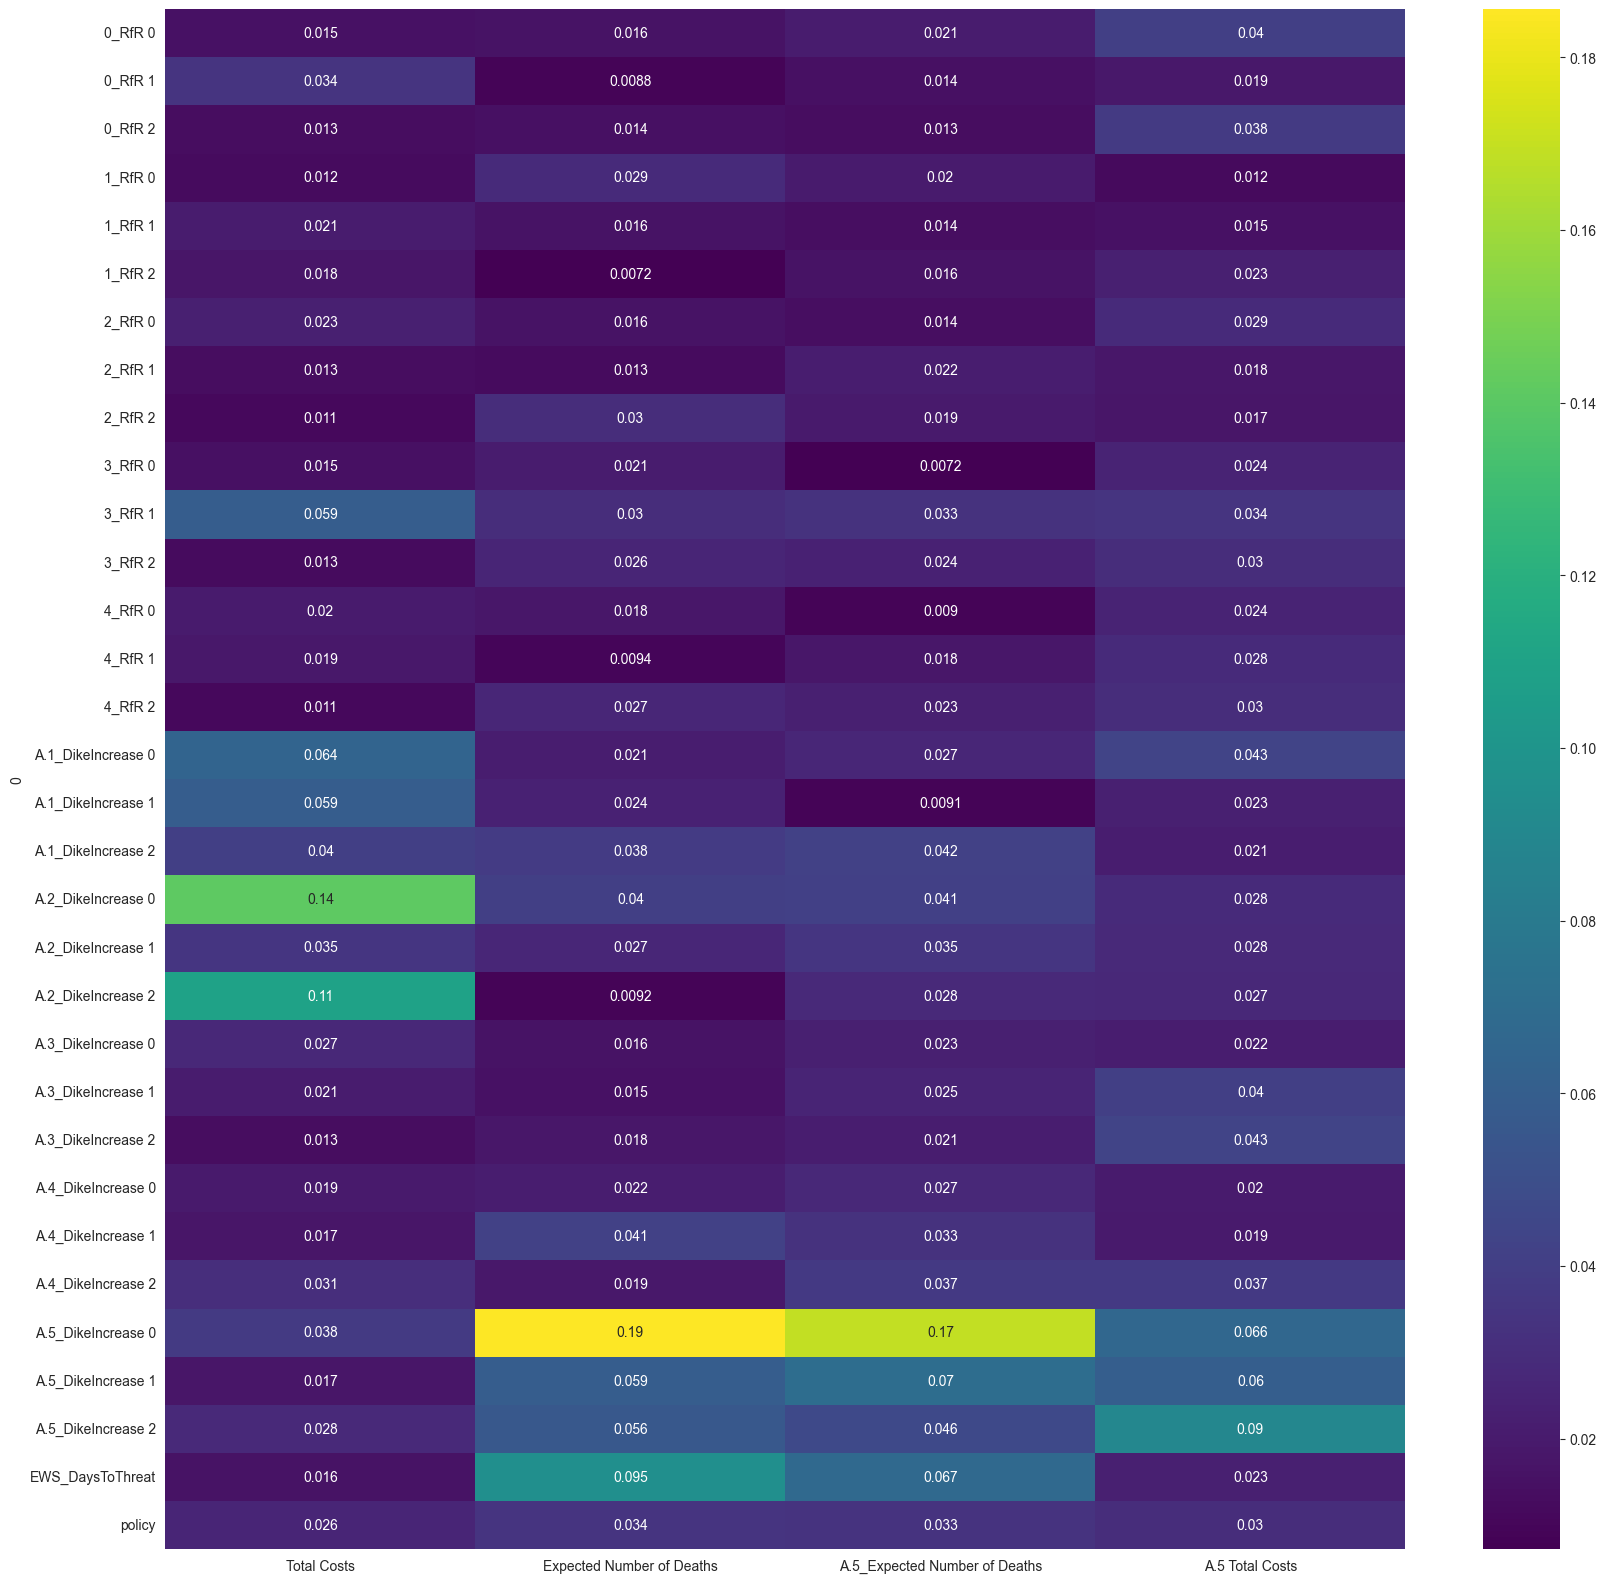

In [24]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df[
    "A.5 Total Costs"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
outcomes_feaimp = outcomes
df_feature_importance_out = df[
    ["Total Costs", "Expected Number of Deaths", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
## Feature importance

x = experiments_unc
y = df_feature_importance_out
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()